# KAGGLE

In [1]:
#Upload json kaggle
%%capture
!pip install kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d shyamsundaravce/ipg-carmaker

100% 1.74G/1.74G [01:17<00:00, 32.0MB/s]
100% 1.74G/1.74G [01:17<00:00, 24.0MB/s]


In [3]:
%%capture
!unzip  /content/ipg-carmaker.zip

# LIBRARIES INSTALLED

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import csv
import os

In [75]:
df = pd.read_csv('/content/run_121527.csv',delimiter='\t', 
                 names=['Steering', 'TimeStamp'])
folder_path = '/content/ds_1/ds_1/images'
# Replace with the path to your folder
data = os.listdir(folder_path)
def sort_key(file_name):
    number_str = file_name.split('-')[1].split('.')[0]
    return int(number_str)

files = sorted(data, key=sort_key, reverse=False)
df['Image'] = files
last_column = df.pop('Image')
df.insert(0, 'Image', last_column)

df.head()

,Image,Steering,TimeStamp
0,movie-0000.jpg,0.0,0.0
1,movie-0001.jpg,0.0,0.2
2,movie-0002.jpg,0.0,0.4
3,movie-0003.jpg,0.0,0.6
4,movie-0004.jpg,0.0,0.8


In [76]:

def append_suffix(im_path):
  if isinstance(im_path, str):
    img_name, im_format = im_path.split('.')
    colab_path = '/content/ds_1/ds_1/images'
    actual_path = colab_path + "/" + img_name +'.' + im_format
    return actual_path
  else:
    return im_path


filtered_df = df[(df['Steering'] > 0.003) | (df['Steering'] < -0.003)]
indices_to_drop = filtered_df[(filtered_df['Steering'] >  0.003)  |(filtered_df['Steering'] < -0.003)].index
rows_to_drop = list(indices_to_drop)
final_df = df.drop(rows_to_drop)
filtered_df= filtered_df.dropna()
filtered_df['Image'] = filtered_df['Image'].apply(append_suffix)
filtered_df.to_csv("Delete.csv", encoding='utf-8', index=False)

print('cut off minimum steer:',final_df['Steering'].min())
print('cut off maximum steer:',final_df['Steering'].max())
print('length of dataset after removal',len(final_df))
print('dataset to be removed',len(filtered_df))

cut off minimum steer: -0.0029974249
cut off maximum steer: 0.0029998566
length of dataset after removal 25714
dataset to be removed 5798


In [77]:
filtered_df.head()

,Image,Steering,TimeStamp
31,/content/ds_1/ds_1/images/movie-0031.jpg,-0.004398,6.2
32,/content/ds_1/ds_1/images/movie-0032.jpg,-0.005889,6.4
33,/content/ds_1/ds_1/images/movie-0033.jpg,-0.005999,6.6
34,/content/ds_1/ds_1/images/movie-0034.jpg,-0.006189,6.8
35,/content/ds_1/ds_1/images/movie-0035.jpg,-0.006440,7.0


In [78]:
%%capture
csv_file = r'/content/Delete.csv'
column_name = "Image"
with open(csv_file, "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        file_path = row[column_name]
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"{file_path} has been deleted.")
        else:
            print(f"{file_path} does not exist.")

PREPARITON : CROPPING AND RESIZING

In [79]:
!mkdir ds1_PreProcessed

In [80]:
%%capture
files_count=0
def prepare_files(dir_name):
    global files_count
    folder_path = dir_name
    writing_path = '/content/ds1_PreProcessed'
    print("*** Processing ", len(os.listdir(dir_name)), "files from", dir_name)
    for file in os.listdir(folder_path):
        if ".png" in file or ".jpg" in file:
            pt = os.path.join(folder_path,file)
            img = cv2.imread(pt)
            img = img[55:156,:,:]
            img = cv2.resize(img, (200, 66))

            file_name = os.path.basename(file)

            cv2.imwrite(f"{writing_path}/{file_name}", img)
            files_count+=1
            print("Processed:{} files ".format(files_count))

prepare_files('/content/ds_1/ds_1/images')

In [ ]:
!mkdir vgg16_PreProcessed

In [ ]:
%%capture
files_count=0
def prepare_files(dir_name):
    global files_count
    folder_path = dir_name
    writing_path = '/content/vgg16_PreProcessed'
    print("*** Processing ", len(os.listdir(dir_name)), "files from", dir_name)
    for file in os.listdir(folder_path):
        if ".png" in file or ".jpg" in file:
            pt = os.path.join(folder_path,file)
            img = cv2.imread(pt)
            img = img[55:156,:,:]
            img = cv2.resize(img, (224, 224))

            file_name = os.path.basename(file)

            cv2.imwrite(f"{writing_path}/{file_name}", img)
            files_count+=1
            print("Processed:{} files ".format(files_count))

prepare_files('/content/ds_2/ds_2/images')

In [81]:
final_df.head()

,Image,Steering,TimeStamp
0,movie-0000.jpg,0.0,0.0
1,movie-0001.jpg,0.0,0.2
2,movie-0002.jpg,0.0,0.4
3,movie-0003.jpg,0.0,0.6
4,movie-0004.jpg,0.0,0.8


PREPARTION: ADDING SUFFIX FOR MODEL FEED

In [82]:
def append_suffix(im_path):
  if isinstance(im_path, str):
    img_name, im_format = im_path.split('.')
    colab_path = '/content/ds1_PreProcessed'
    actual_path = colab_path + "/" + img_name +'.' + im_format
    return actual_path
  else:
    return im_path

final_df= final_df.dropna()
final_df['Image'] = final_df['Image'].apply(append_suffix)


In [83]:
global min_val
global max_val
def radians_to_degrees(radians):
    return radians * 180 / np.pi

final_df["degree"] = final_df["Steering"].apply(radians_to_degrees)
min_val = final_df["degree"].min()
max_val = final_df["degree"].max()
# normalize the values between 0 and 1
final_df["norm"] = (final_df["degree"] - min_val) / (max_val - min_val)
#Normlizae between -1 and 1
# final_df['norm'] =2 *  ((df['degree'] - min_val) / (max_val - min_val)) - 1
#Revert back
#(((df['degnorm'] + 1) * (max_val - min_val)) / 2) + min_val
print('normalized max value',final_df['norm'].max())

normalized max value 1.0


[ 359  454  513  618  797 1977 3332 7766 3340 1979  795  680  470  454
  333]


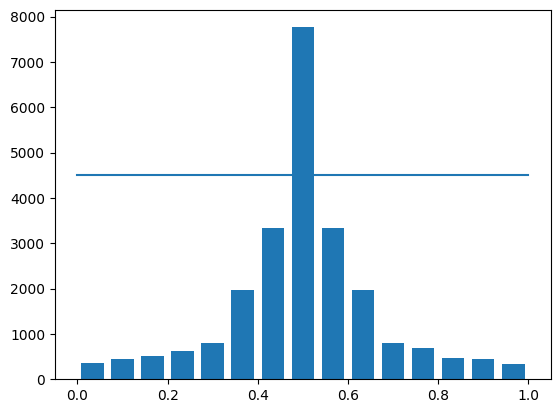

In [89]:
# final_df = pd.read_csv('final.csv')
steering = np.asarray(final_df['norm'].values)
num_bins = 15
samples_per_bin = 4500
hist, bins = np.histogram(steering, num_bins)
print(hist)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(steering), np.max(steering)), (samples_per_bin, samples_per_bin))

In [90]:
import collections
counter = collections.Counter()

# Count the number of samples in each bin
for i in range(num_bins):

    counter[f'{bins[i]:.3f}-{bins[i+1]:.3f}'] = hist[i]

# Print the counts for each bin
for key, value in counter.items():
    print(f'{key}: {value}')

0.000-0.067: 359
0.067-0.133: 454
0.133-0.200: 513
0.200-0.267: 618
0.267-0.333: 797
0.333-0.400: 1977
0.400-0.467: 3332
0.467-0.533: 7766
0.533-0.600: 3340
0.600-0.667: 1979
0.667-0.733: 795
0.733-0.800: 680
0.800-0.867: 470
0.867-0.933: 454
0.933-1.000: 333


Run this code for normalization and stop once it once 

In [88]:

indices_to_drop = (final_df['norm'] >= 0.667) & (final_df['norm'] <= 0.733)
rows_to_drop = final_df[indices_to_drop].index
records_to_delete = 736
dropped_list = np.random.choice(rows_to_drop, size=records_to_delete, replace=False)
final_df.drop(dropped_list, inplace=True)

In [91]:

ipg_np = np.array(final_df)
#Balance the steering data
print ('total data', len(final_df))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(steering)):
    if steering[i] >= bins[j] and steering[i]<=bins[j+1]:
      #print(i)
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print ('removed', len(remove_list))

print (np.max(remove_list))

train_data = np.delete(ipg_np, remove_list, axis=0)

print ('remaining:', len (train_data))


total data 23867
removed 3266
23855
remaining: 20601


0.49979726647815353


<BarContainer object of 15 artists>

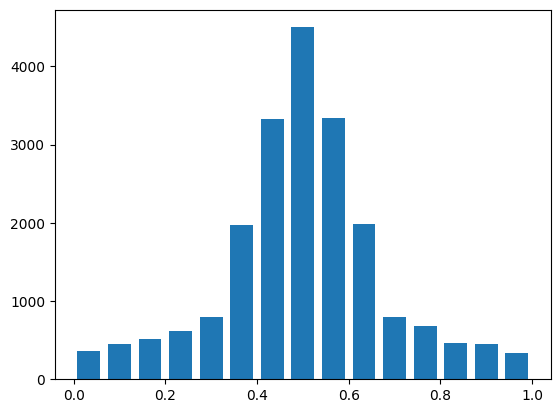

In [92]:
#Plot balanced Steering Data
steering = []
for i in range(len(train_data)):
  steering.append(train_data[i][4])
print(steering[1])
num_bins = 15
samples_per_bin = 4500
hist, bins = np.histogram(steering, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)

In [100]:
image =[]
labels =[]
for i in range(len(train_data)):

  img,steer,ts,degree,norm = train_data[i]
  image.append(img)
  labels.append(norm)
X_train, X_valid, y_train, y_valid = train_test_split(
    image, labels, test_size=0.2, random_state=0
)

Text(0.5, 1.0, 'Validation set')

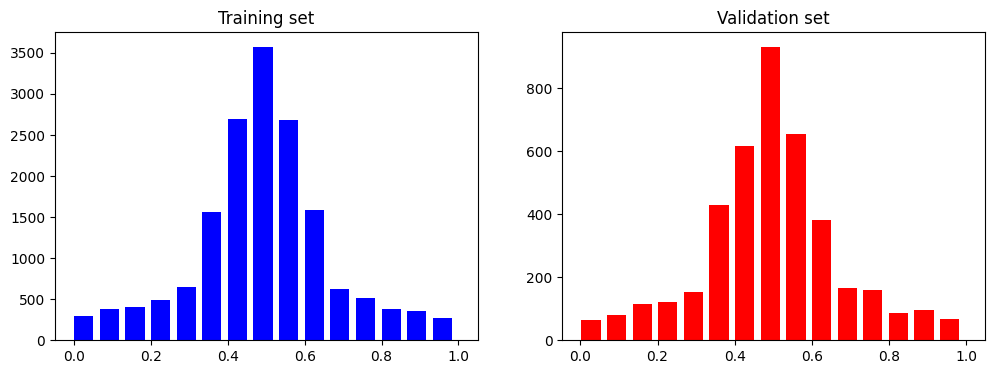

In [101]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
axis[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axis[0].set_title("Training set")
axis[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axis[1].set_title("Validation set")

In [102]:
def generator(img_path,steering,batch_size):
  while True:
    for idx in range(0,len(img_path),batch_size):
      imgpath_batch = img_path[idx : idx+batch_size]
      batch_steer = steering[idx : idx+batch_size]
      lane_img = [cv2.imread(path) for path in imgpath_batch]
      yield np.asarray(lane_img),np.asarray(batch_steer)

# NVIDIA PILOTNET

In [103]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Dropout, Flatten, Dense,Lambda

model = Sequential()
model.add(Lambda(lambda x: x/127.5 -1., input_shape=(66, 200, 3)))
model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2),activation='elu'))
model.add(Conv2D(filters=36, kernel_size=(5, 5),strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2),activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3) ,activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3),activation='relu'))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 66, 200, 3)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

In [ ]:
# from keras.models import Sequential
# from keras.layers import Flatten, Dense, Lambda
# from keras.layers.core import Dense, Activation, Flatten, Dropout
# from keras.optimizers import Adam
# from keras.layers.convolutional import Conv2D
# from keras.layers.pooling import MaxPooling2D

# model = Sequential()
# model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(66,200, 3)))
# model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2),activation='elu'))
# model.add(Conv2D(filters=36, kernel_size=(5, 5),strides=(2, 2), activation='elu'))
# model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2),activation='elu'))
# model.add(Conv2D(filters=64, kernel_size=(3, 3) ,activation='elu'))
# model.add(Conv2D(filters=64, kernel_size=(3, 3),activation='elu'))
# model.add(Flatten())
# #model.add(Dense(units=1164, activation='relu'))
# model.add(Dense(units=100, activation='elu'))
# model.add(Dense(units=50, activation='elu'))
# model.add(Dense(units=10, activation='elu'))
# model.add(Dense(units=1))
# print(model.summary())


In [104]:
from keras.metrics import RootMeanSquaredError
from keras.callbacks import  EarlyStopping
# es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
miniBatch_size = 32;
history = model.fit(generator(X_train, y_train, miniBatch_size),
                    epochs=20,
                    steps_per_epoch=int(len(X_train)/miniBatch_size),
                    validation_data=generator(X_valid, y_valid,miniBatch_size),
                    validation_steps=int(len(X_valid)/miniBatch_size),
                    shuffle=True)
                    # callbacks=[es])
model.save('ds1_ipg.h5')

Epoch 1/20
515/515 [==============================] - 45s 20ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836
Epoch 2/20
515/515 [==============================] - 8s 15ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749
Epoch 3/20
515/515 [==============================] - 9s 17ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 4/20
515/515 [==============================] - 9s 17ms/step - loss: 0.0035 - root_mean_squared_error: 0.0592 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 5/20
515/515 [==============================] - 7s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 6/20
515/515 [==============================] - 9s 17ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0040

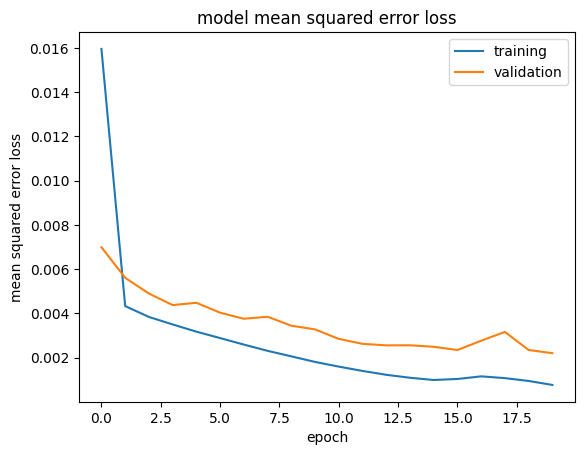

In [105]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [106]:
%%capture
import math
import tensorflow as tf

model = tf.keras.models.load_model(r"ds1_ipg.h5")
scount = 0

def predict_image(image_path):
    global scount
    image = cv2.imread(image_path)
    # Convert the image to a numpy array
    steering = model.predict(image[None, :, :, :], batch_size=1)[0][0].astype(float)
    scount+=1
    print("files count:{}, steering:{}".format(scount,steering))
    return steering

def degrees_to_radians(degrees):
    return degrees * math.pi / 180

#Cut off for Image Scene
cuf_off = final_df[1280:1450]
cuf_off["PredDeg"] = cuf_off["Image"].apply(predict_image)
cuf_off['PredDegDeNorm'] = (cuf_off['PredDeg'] * (max_val - min_val)) + min_val
cuf_off["PredconvRadian"] = cuf_off["PredDegDeNorm"].apply(degrees_to_radians)

steering_actual = cuf_off["norm"]
timestamps = cuf_off["TimeStamp"]
steering_prediction = cuf_off['PredDeg']

In [107]:
cuf_off.head(10)

,Image,Steering,TimeStamp,degree,norm,PredDeg,PredDegDeNorm,PredconvRadian
1592,/content/ds1_PreProcessed/movie-1592.jpg,-0.002405,318.4,-0.137775,0.098845,0.132403,-0.126244,-0.002203
1593,/content/ds1_PreProcessed/movie-1593.jpg,-0.001994,318.6,-0.114249,0.167311,0.129066,-0.127390,-0.002223
1594,/content/ds1_PreProcessed/movie-1594.jpg,-0.001569,318.8,-0.089892,0.238194,0.183865,-0.108560,-0.001895
1595,/content/ds1_PreProcessed/movie-1595.jpg,-0.001139,319.0,-0.065242,0.309929,0.286464,-0.073305,-0.001279
1596,/content/ds1_PreProcessed/movie-1596.jpg,-0.000723,319.2,-0.041409,0.379288,0.388609,-0.038206,-0.000667
1597,/content/ds1_PreProcessed/movie-1597.jpg,-0.000303,319.4,-0.017372,0.449242,0.450166,-0.017054,-0.000298
1598,/content/ds1_PreProcessed/movie-1598.jpg,0.000117,319.6,0.006678,0.519232,0.490953,-0.003039,-0.000053
1599,/content/ds1_PreProcessed/movie-1599.jpg,0.000518,319.8,0.029702,0.586236,0.556855,0.019606,0.000342
1600,/content/ds1_PreProcessed/movie-1600.jpg,0.000898,320.0,0.051473,0.649594,0.667490,0.057623,0.001006
1601,/content/ds1_PreProcessed/movie-1601.jpg,0.001277,320.2,0.073162,0.712715,0.692145,0.066094,0.001154


In [109]:
def show_actual():
    fig, ax = plt.subplots()
    ax.plot(timestamps, steering_actual, color='darkblue', label='Actual')
    # ax.plot(timestamps, steering_prediction, color='darkOrange', label='Prediction')
    ax.legend()
    ax.set_xlabel('Timestamp(seconds)')
    ax.set_ylabel('Steering Angle (radians)')
    ax.set_title('Actual Steering Angle')
    plt.show()

def show_prediction():
    fig, ax = plt.subplots()
    ax.plot(timestamps, steering_prediction, color='darkOrange', label='Prediction')
    ax.legend()
    ax.set_xlabel('Timestamp(seconds)')
    ax.set_ylabel('Steering Angle(radians)')
    ax.set_title('Predicted Steering Angle')

    plt.show()

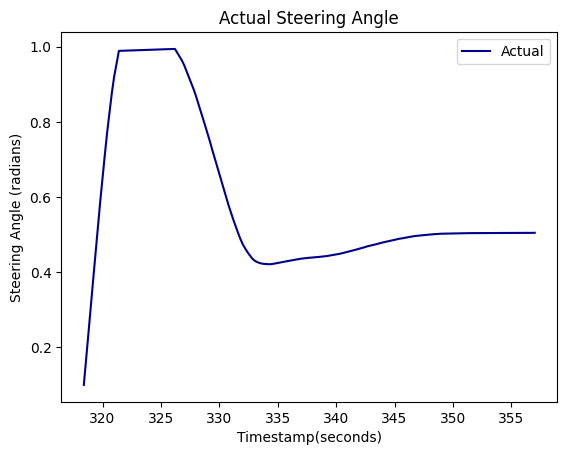

In [110]:
show_actual()

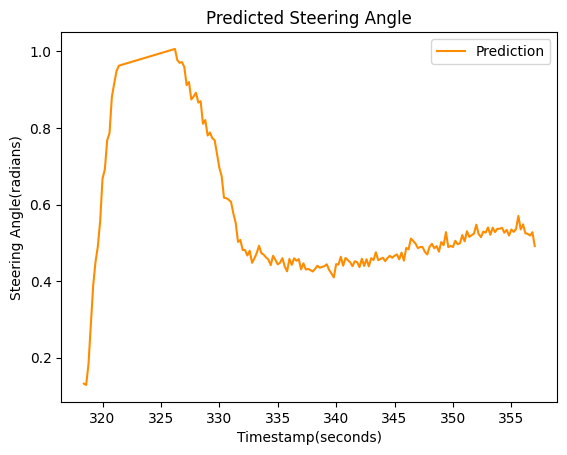

In [111]:
show_prediction()

# TRANSFER LEARNING

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import  VGG16
from keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization,Lambda
from keras.optimizers import Adam

def normalize_input(x):
    return x/255


mod_shape = (66, 200, 3)
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))
# input_layer = Lambda(normalize_input, input_shape=mod_shape)(base_model.input),

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1164,activation='relu')(x)
x = Dense(100,activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(50,activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(10,activation='relu')(x)
predictions = Dense(1)(x)
model =  Model(inputs=base_model.input,outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from keras.metrics import RootMeanSquaredError
from keras.callbacks import  EarlyStopping
# es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
miniBatch_size = 32;

history = model.fit(generator(X_train, y_train, miniBatch_size),
                    epochs=10,
                    steps_per_epoch=int(len(X_train)/miniBatch_size),
                    validation_data=generator(X_valid, y_valid,miniBatch_size),
                    validation_steps=int(len(X_valid)/miniBatch_size),
                    shuffle=True)
model.save('ds2_vgg16ipg.h5')

Epoch 1/10
542/542 [==============================] - 91s 145ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938
Epoch 2/10
542/542 [==============================] - 85s 151ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 3/10
542/542 [==============================] - 87s 160ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 4/10
542/542 [==============================] - 83s 154ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 5/10
542/542 [==============================] - 84s 156ms/step - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 6/10
542/542 [==============================] - 88s 163ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_l

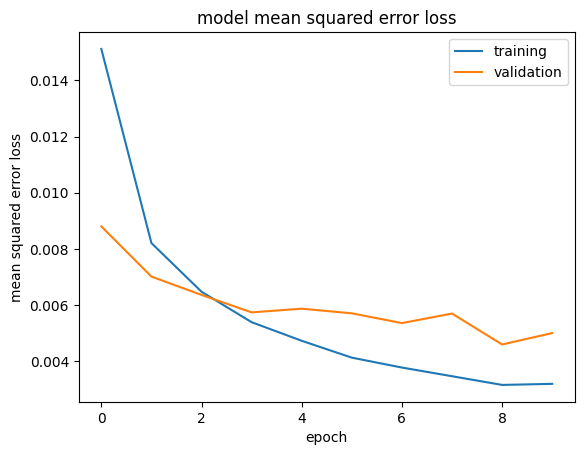

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
scount=0
def predict_image(image_path):
    global scount
    image = cv2.imread(image_path)
    # image = image /255
    # Convert the image to a numpy array
    steering = model.predict(image[None, :, :, :], batch_size=1)[0][0].astype(float)
    scount+=1
    # print("files count:{}, steering:{}".format(scount,steering))
    return steering

def degrees_to_radians(degrees):
    return degrees * math.pi / 180

cut_off = final_df[1250:1300]
cut_off["PredDeg"] = cut_off["Image"].apply(predict_image)

1/1 [==============================] - 0s 20ms/step


<ipython-input-33-da1397ae1eb3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off["PredDeg"] = cut_off["Image"].apply(predict_image)


In [ ]:
cut_off.head(50)

,Image,Steering,TimeStamp,degree,norm,PredDeg
2268,/content/vgg16_PreProcessed/movie-2268.jpg,-0.000182,453.6,-0.010414,0.469806,0.480102
2269,/content/vgg16_PreProcessed/movie-2269.jpg,-0.000291,453.8,-0.016658,0.451638,0.479986
2270,/content/vgg16_PreProcessed/movie-2270.jpg,-0.000385,454.0,-0.022058,0.435929,0.395354
2271,/content/vgg16_PreProcessed/movie-2271.jpg,-0.000458,454.2,-0.026267,0.423681,0.456362
2272,/content/vgg16_PreProcessed/movie-2272.jpg,-0.000521,454.4,-0.029868,0.413202,0.401140
2273,/content/vgg16_PreProcessed/movie-2273.jpg,-0.000565,454.6,-0.032347,0.405991,0.465701
2274,/content/vgg16_PreProcessed/movie-2274.jpg,-0.000590,454.8,-0.033789,0.401795,0.414213
2275,/content/vgg16_PreProcessed/movie-2275.jpg,-0.000587,455.0,-0.033626,0.402269,0.367493
2276,/content/vgg16_PreProcessed/movie-2276.jpg,-0.000540,455.2,-0.030938,0.410090,0.438554
2277,/content/vgg16_PreProcessed/movie-2277.jpg,-0.000457,455.4,-0.026182,0.423927,0.460243





# DATASET 3 PREPROCESSING

In [113]:
import shutil

# Specify the directory path to be removed
directory_path = "/content/ds_3"

# Remove the directory and all its contents
shutil.rmtree(directory_path)


In [114]:
%%capture
!kaggle datasets download -d shyamsundaravce/ipgcarmker-ds3

!unzip  /content/ipgcarmker-ds3.zip




In [115]:
len(os.listdir('/content/ds_3/ds_3/images'))

30432

In [116]:
df = pd.read_csv(r'/content/run_13052023.csv')
df = df.drop(df.index[-1])#There is one excess record
folder_path = r'/content/ds_3/ds_3/images'
# Replace with the path to your folder
data = os.listdir(folder_path)
def sort_key(file_name):
    number_str = file_name.split('-')[1].split('.')[0]
    return int(number_str)

files = sorted(data, key=sort_key, reverse=False)
df['Image'] = files
last_column = df.pop('Image')
df.insert(0, 'Image', last_column)


def append_suffix(im_path):
  if isinstance(im_path, str):
    img_name, im_format = im_path.split('.')
    colab_path = '/content/ds_3/ds_3/images'
    actual_path = colab_path + "/" + img_name +'.' + im_format
    return actual_path
  else:
    return im_path


filtered_df = df[(df['Steering'] > 0.003) | (df['Steering'] < -0.003)]
indices_to_drop = filtered_df[(filtered_df['Steering'] >  0.003)  |(filtered_df['Steering'] < -0.003)].index
rows_to_drop = list(indices_to_drop)
final_df = df.drop(rows_to_drop)
filtered_df= filtered_df.dropna()
filtered_df['Image'] = filtered_df['Image'].apply(append_suffix)
filtered_df.to_csv("Delete.csv", encoding='utf-8', index=False)

print('cut off minimum steer:',final_df['Steering'].min())
print('cut off maximum steer:',final_df['Steering'].max())
print('length of dataset after removal',len(final_df))
print('dataset to be removed',len(filtered_df))

cut off minimum steer: -0.002998968
cut off maximum steer: 0.002999177
length of dataset after removal 27127
dataset to be removed 3305


In [ ]:
#Please run at once to delete the files using delete.csv
csv_file = "/content/Delete.csv"
column_name = "Image"
with open(csv_file, "r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        file_path = row[column_name]
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"{file_path} has been deleted.")
        else:
            print(f"{file_path} does not exist.")

In [117]:
!mkdir ds3_PreProcessed

In [119]:
%%capture
files_count=0
def prepare_files(dir_name):
    global files_count
    folder_path = dir_name
    writing_path = "/content/ds3_PreProcessed"
    print("*** Processing ", len(os.listdir(dir_name)), "files from", dir_name)
    for file in os.listdir(folder_path):
        if ".png" in file or ".jpg" in file:
            pt = os.path.join(folder_path,file)
            img = cv2.imread(pt)
            img = img[55:156,:,:]
            img = cv2.resize(img, (200, 66))

            file_name = os.path.basename(file)

            cv2.imwrite(f"{writing_path}/{file_name}", img)
            files_count+=1
            # print("Processed:{} files ".format(files_count))

prepare_files("/content/ds_3/ds_3/images")
print("Processed:{} files ".format(files_count))

In [120]:
def append_suffix(im_path):
  if isinstance(im_path, str):
    img_name, im_format = im_path.split('.')
    colab_path = '/content/ds3_PreProcessed'
    actual_path = colab_path + "/" + img_name +'.' + im_format
    return actual_path
  else:
    return im_path

final_df= final_df.dropna()
final_df['Image'] = final_df['Image'].apply(append_suffix)


In [121]:
final_df.head()

,Image,Steering,TimeStamp
0,/content/ds3_PreProcessed/movie-0000.jpg,0.0,0.0
1,/content/ds3_PreProcessed/movie-0001.jpg,0.0,0.0
2,/content/ds3_PreProcessed/movie-0002.jpg,0.0,0.2
3,/content/ds3_PreProcessed/movie-0003.jpg,0.0,0.4
4,/content/ds3_PreProcessed/movie-0004.jpg,0.0,0.6




# DATASET 3 PREDICTIONS

In [122]:

global d3min_val
global d3max_val
def radians_to_degrees(radians):
    return radians * 180 / np.pi

final_df["degree"] = final_df["Steering"].apply(radians_to_degrees)
final_df = final_df[7060:7300]
d3min_val = final_df["degree"].min()
d3max_val = final_df["degree"].max()
# normalize the values between 0 and 1
final_df["norm"] = (final_df["degree"] - d3min_val) / (d3max_val - d3min_val)
#Normlizae between -1 and 1
# final_df['norm'] =2 *  ((df['degree'] - min_val) / (max_val - min_val)) - 1
#Revert back
#(((df['degnorm'] + 1) * (max_val - min_val)) / 2) + min_val
print('normalized max value',final_df['norm'].max())

normalized max value 1.0


<ipython-input-122-dce85a4e1abc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["norm"] = (final_df["degree"] - d3min_val) / (d3max_val - d3min_val)


In [123]:
final_df.head()

,Image,Steering,TimeStamp,degree,norm
7184,/content/ds3_PreProcessed/movie-7184.jpg,0.000690,1436.6,0.039545,0.617297
7185,/content/ds3_PreProcessed/movie-7185.jpg,0.000703,1436.8,0.040262,0.619391
7186,/content/ds3_PreProcessed/movie-7186.jpg,0.000715,1437.0,0.040946,0.621390
7187,/content/ds3_PreProcessed/movie-7187.jpg,0.000726,1437.2,0.041585,0.623257
7188,/content/ds3_PreProcessed/movie-7188.jpg,0.000737,1437.4,0.042222,0.625118


In [124]:
%%capture
import tensorflow as tf
import math
model = tf.keras.models.load_model("/content/ds1_ipg.h5")
scount = 0
def predict_image(image_path):
    global scount
    image = cv2.imread(image_path)
    # image = image /255
    # Convert the image to a numpy array
    steering = model.predict(image[None, :, :, :], batch_size=1)[0][0].astype(float)
    scount+=1
    # print("files count:{}, steering:{}".format(scount,steering))
    return steering

def degrees_to_radians(degrees):
    return degrees * math.pi / 180

cuf_off = final_df# First 288
cuf_off["PredDeg"] = cuf_off["Image"].apply(predict_image)
cuf_off['PredDeNorm'] = (cuf_off['PredDeg'] * (d3max_val - d3min_val)) + d3min_val
cuf_off["PredRadian"] = cuf_off["PredDeNorm"].apply(degrees_to_radians)

In [125]:
cuf_off.head(10)

,Image,Steering,TimeStamp,degree,norm,PredDeg,PredDeNorm,PredRadian
7184,/content/ds3_PreProcessed/movie-7184.jpg,0.000690,1436.6,0.039545,0.617297,0.298879,-0.069441,-0.001212
7185,/content/ds3_PreProcessed/movie-7185.jpg,0.000703,1436.8,0.040262,0.619391,0.236306,-0.090858,-0.001586
7186,/content/ds3_PreProcessed/movie-7186.jpg,0.000715,1437.0,0.040946,0.621390,0.280394,-0.075767,-0.001322
7187,/content/ds3_PreProcessed/movie-7187.jpg,0.000726,1437.2,0.041585,0.623257,0.336207,-0.056664,-0.000989
7188,/content/ds3_PreProcessed/movie-7188.jpg,0.000737,1437.4,0.042222,0.625118,0.259173,-0.083031,-0.001449
7189,/content/ds3_PreProcessed/movie-7189.jpg,0.000747,1437.6,0.042808,0.626831,0.297211,-0.070011,-0.001222
7190,/content/ds3_PreProcessed/movie-7190.jpg,0.000755,1437.8,0.043280,0.628209,0.376678,-0.042812,-0.000747
7191,/content/ds3_PreProcessed/movie-7191.jpg,0.000762,1438.0,0.043653,0.629299,0.287996,-0.073165,-0.001277
7192,/content/ds3_PreProcessed/movie-7192.jpg,0.000766,1438.2,0.043914,0.630061,0.280584,-0.075702,-0.001321
7193,/content/ds3_PreProcessed/movie-7193.jpg,0.000771,1438.4,0.044173,0.630820,0.383637,-0.040430,-0.000706


In [126]:
steering_actual = cuf_off["norm"]
timestamps = cuf_off["TimeStamp"]
steering_prediction = cuf_off['PredDeg']
def show_actual():
    fig, ax = plt.subplots()
    ax.plot(timestamps, steering_actual, color='darkblue', label='Actual')
    # ax.plot(timestamps, steering_prediction, color='darkOrange', label='Prediction')
    ax.legend()
    ax.set_xlabel('Timestamp(seconds)')
    ax.set_ylabel('Steering Angle(Radians)')
    ax.set_title('Actual Steering Angle ')
    plt.show()

def show_prediction():
    fig, ax = plt.subplots()
    ax.plot(timestamps, steering_prediction, color='darkOrange', label='Prediction')
    ax.legend()
    ax.set_xlabel('Timestamp(seconds)')
    ax.set_ylabel('Steering Angle(Radians)')
    ax.set_title('Predicted Steering Angle')

    plt.show()





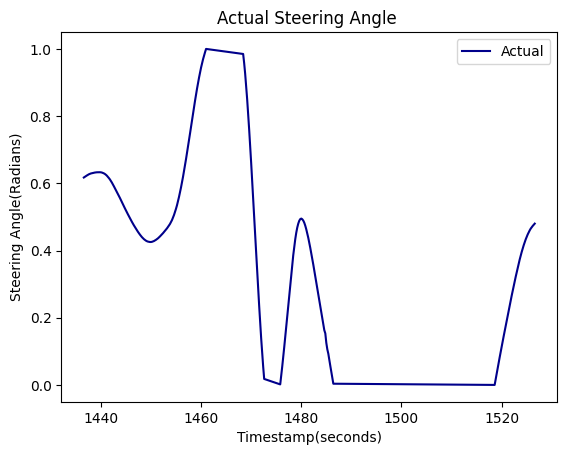

In [127]:
show_actual()

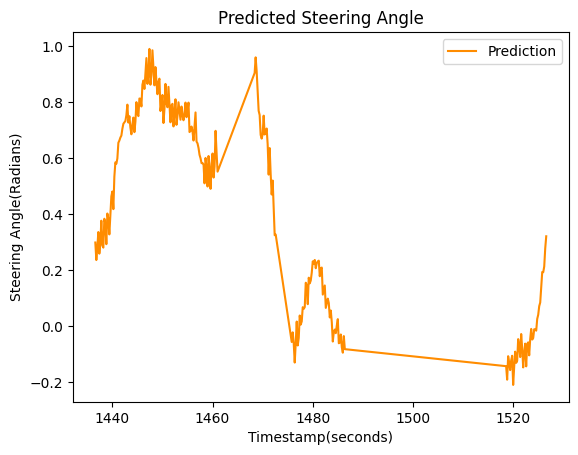

In [128]:
show_prediction()

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(r"/content/ds2_vgg16ipg.h5")
scount = 0

def predict_image(image_path):
    global scount
    image = cv2.imread(image_path)
    # Convert the image to a numpy array
    image = image /255
    steering = model.predict(image[None, :, :, :], batch_size=1)[0][0].astype(float)
    scount+=1
    print("files count:{}, steering:{}".format(scount,steering))
    return steering
vgg16_df = df[0:500]
vgg16_df["VGG16_PredDeg"] = vgg16_df["Image"].apply(predict_image)
vgg16_df.to_csv('VGG16-DS2PRED3.csv',index=False)

1/1 [==============================] - 0s 231ms/step
files count:1, steering:0.09607943147420883
1/1 [==============================] - 0s 25ms/step
files count:2, steering:0.09607943147420883
1/1 [==============================] - 0s 25ms/step
files count:3, steering:0.09607943147420883
1/1 [==============================] - 0s 25ms/step
files count:4, steering:0.09607943147420883
1/1 [==============================] - 0s 29ms/step
files count:5, steering:0.09607943147420883
1/1 [==============================] - 0s 28ms/step
files count:6, steering:0.09607943147420883
1/1 [==============================] - 0s 29ms/step
files count:7, steering:0.09607943147420883
1/1 [==============================] - 0s 36ms/step
files count:8, steering:0.09607943147420883
1/1 [==============================] - 0s 28ms/step
files count:9, steering:0.09607943147420883
1/1 [==============================] - 0s 25ms/step
files count:10, steering:0.09607943147420883
1/1 [==============================] -

<ipython-input-71-448749b4a60f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vgg16_df["VGG16_PredDeg"] = vgg16_df["Image"].apply(predict_image)


In [ ]:
df1 = pd.read_csv('/content/NVIDIA_DS2PRED3.csv')
df2 = pd.read_csv('/content/VGG16-DS2PRED3.csv')
df3 = pd.DataFrame(df2['Image'],
                   columns=['Image'],
                   index=None)
df3['NVIDIA_PredDeg'] = df1['NVIDIA_PredDeg']
df3['VGG16_PredDeg'] =df2['VGG16_PredDeg']
timestamp = np.arange(len(df3)) * 0.2
df3['Timestamp'] = timestamp
df3.to_csv('ds2_comparision.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# corner_check = pd.read_csv('RUN1-VGG16_170.csv')
steering_nvidia = df3['NVIDIA_PredDeg'] 
timestamps = df3["Timestamp"]
steering_vgg16 = df3['VGG16_PredDeg']

def show_nvidia():
    fig, ax = plt.subplots()
    ax.plot(timestamps, steering_nvidia, color='darkblue', label='Actual')
    # ax.plot(timestamps, steering_prediction, color='darkOrange', label='Prediction')
    ax.legend()
    ax.set_xlabel('Timestamp')

    ax.set_ylabel('NVDIA Steering Angle(degrees)')
    ax.set_title('NVDIA Steering Angle')
    plt.show()


def show_vgg16():
    fig, ax = plt.subplots()
    ax.plot(timestamps, steering_vgg16, color='darkOrange', label='Prediction')
    ax.legend()
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('VGG16 Steering Angle(degrees)')
    ax.set_title('VGG16 Steering Angle')
    plt.show()

# show_prediction()

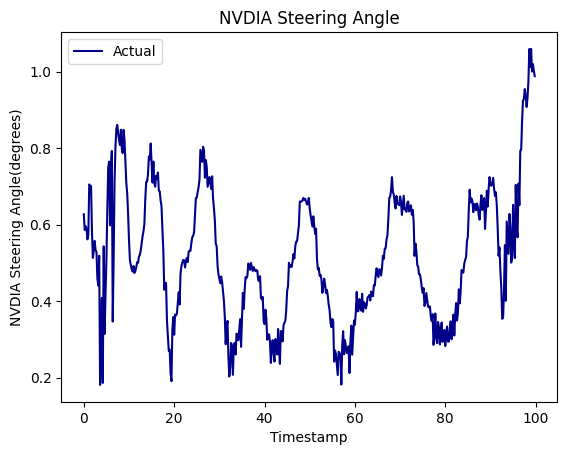

In [ ]:
show_nvidia()

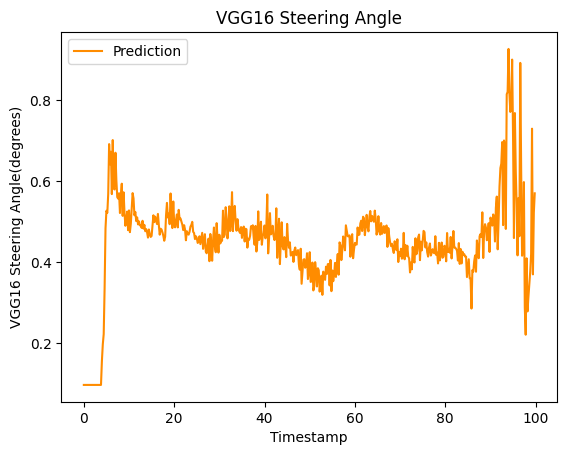

In [ ]:
show_vgg16()